# Plot Trade-offs
- Speed-quality trade-off (Fig. 6)
- FID-precision trade-off (Fig. 8)

In [ ]:
%cd ../

In [2]:
import json
import os
import re
from copy import deepcopy
from datetime import datetime
from glob import glob
from typing import Dict, List, Optional, Tuple, Union

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
from omegaconf import OmegaConf
from tqdm.notebook import tqdm

plt.style.use(['science','no-latex', 'grid'])
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Speed-Quality Trade-off

### Preparation

1. Generate layout using Layout-Corrector with `t={100, 75, 50, 30, 20}`:

`$ for t in 100 75 50 30 20; python ./bin/corrector_test_eval.py ./download/pretrained_weights/rico25/layout_corrector rico25 -t $t -c unconditional --test_only`

2. Generate layout **without** Layout-Corrector with `t={100, 75, 50, 30, 20}`:

`$ for t in 100 75 50 30 20; python ./bin/test_eval.py ./download/pretrained_weights/rico25/layoutdm rico25 -t $t -c unconditional --test_only`

3. Set `result_dirs` below. They should be like `./results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_{TIMESTAMP}`.

In [3]:
dataset_name = 'Rico'

layout_corrector = dict(
    label = 'LayoutDM + Layout Corrector',
    result_dirs = [
        # Update below
        './results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829142353', # t=100
        './results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829142526', # t=75
        './results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829142643', # t=50
        './results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829142739', # t=30
        './results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829142818', # t=20
    ],
    marker = 'o',
)

layoutdm = dict(
    label = 'LayoutDM',
    result_dirs = [
        # Update below
        './results/rico25/layoutdm/unconditional_temperature_1.0_name_random_num_timesteps_100_1000_samples_20240829140547',
        './results/rico25/layoutdm/unconditional_temperature_1.0_name_random_num_timesteps_75_1000_samples_20240829140721',
        './results/rico25/layoutdm/unconditional_temperature_1.0_name_random_num_timesteps_50_1000_samples_20240829140839',
        './results/rico25/layoutdm/unconditional_temperature_1.0_name_random_num_timesteps_30_1000_samples_20240829140937',
        './results/rico25/layoutdm/unconditional_temperature_1.0_name_random_num_timesteps_20_1000_samples_20240829141017',
    ],
    marker = 'x',
)

In [4]:
def load_sampling_cfg(result_dir):
    sampling_cf = os.path.join(result_dir, 'sampling_config.yaml')
    with open(sampling_cf, 'r') as f:
        cfg = OmegaConf.load(f)
    return cfg

def check_timesteps(result_dirs, num_timesteps):
    assert len(result_dirs) == len(num_timesteps)

    for _dir, ts in zip(result_dirs, num_timesteps):
        cfg = load_sampling_cfg(_dir)
        assert cfg.num_timesteps == ts, f'{_dir}: timesteps should be {ts} but {cfg.num_timesteps}'

# Sanity check
num_timesteps = [100, 75, 50, 30, 20]
check_timesteps(layout_corrector['result_dirs'], num_timesteps)
check_timesteps(layoutdm['result_dirs'], num_timesteps)

In [5]:
def load_scores(result_dirs):
    scores = []
    for result_dir in result_dirs:
        json_path = os.path.join(result_dir, 'scores_fake_avg.json')
        with open(json_path, 'r') as f:
            score_dict = json.load(f)
        scores.append(score_dict)
    return scores

# Load scores (FID and runtimes)
layout_corrector['scores'] = load_scores(layout_corrector['result_dirs'])
layoutdm['scores'] = load_scores(layoutdm['result_dirs'])

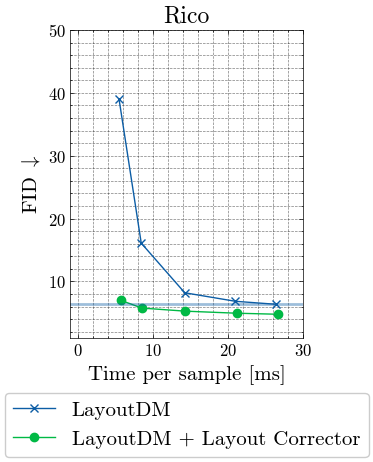

In [6]:
# Plot
fontsize = 15
fig, ax = plt.subplots(1, 1, figsize=(3, 4))

for dic in [layoutdm, layout_corrector]:
    x = [1000 * s['t_total'] / s['N_total'] for s in dic['scores']] # ms per sample
    y =  [s['fid'] for s in dic['scores']]
    ax.plot(x, y, label=dic['label'], marker=dic['marker'])

# draw horizontal line to show FID of LayoutDM (t=100)
layoutdm_fid = layoutdm['scores'][0]['fid']
ax.plot([-100, 100], [layoutdm_fid, layoutdm_fid], lw=2.0, alpha=0.4, color=COLORS[0])

ax.set_xlim(-1, 30)
ax.set_ylim(1, 50)
ax.set_xlabel('Time per sample [ms]', fontsize=fontsize)
ax.set_ylabel(r'FID $\downarrow$', fontsize=fontsize)
ax.tick_params(labelsize=fontsize-3)
ax.set_title(dataset_name, fontsize=fontsize+2)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.42, 0., 0.,), fontsize=fontsize)
ax.grid(visible=True, which='minor', linewidth=0.5);

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('./notebooks/graph.svg')

## FID-Precision Trade-off

### Preparation

1. Generate layout using Layout-Corrector with different corrector schedule: `corrector_t_list = [{10}, {10, 20}, {10, 20, .., 90}]`

- `$ python ./bin/corrector_test_eval.py ./download/pretrained_weights/rico25/layout_corrector rico25 -t $t -c unconditional --test_only --corrector_t_list 10`

- `$ python ./bin/corrector_test_eval.py ./download/pretrained_weights/rico25/layout_corrector rico25 -t $t -c unconditional --test_only --corrector_t_list 10 20`

- `$ python ./bin/corrector_test_eval.py ./download/pretrained_weights/rico25/layout_corrector rico25 -t $t -c unconditional --test_only --corrector_t_list 10 20 30`

- ...

- `$ python ./bin/corrector_test_eval.py ./download/pretrained_weights/rico25/layout_corrector rico25 -t $t -c unconditional --test_only --corrector_t_list 10 20 30 40 50 60 70 80`

- `$ python ./bin/corrector_test_eval.py ./download/pretrained_weights/rico25/layout_corrector rico25 -t $t -c unconditional --test_only --corrector_t_list 10 20 30 40 50 60 70 80 90`

2. Set `result_dirs` below.

In [7]:
dataset_name = 'Rico'

layout_corrector = dict(
    label = 'LayoutDM + Layout Corrector',
    result_dirs = [
        # Update below
        './results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829150224', # {10}
        './results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829150357', # {10, 20}
        './results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829150534', # {10, ..., 30}
        './results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829150714', # {10, ..., 40}
        './results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829161223', # {10, ..., 50}
        './results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829161446', # {10, ..., 60}
        './results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829172858', # {10, ..., 70}
        './results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829173335', # {10, ..., 80}
        './results/rico25/layout_corrector/unconditional_thresh_0.7_1000_samples_20240829173724', # {10, ..., 90}
    ],
    marker = 'o',
)

layoutdm = dict(
    label = 'LayoutDM',
    result_dirs = [
        # Update below
        './results/rico25/layoutdm/unconditional_temperature_1.0_name_random_num_timesteps_100_1000_samples_20240829140547'
    ],
    marker = 'x',
)

In [8]:
# Check corrector_t_list in result_dirs
for i, result_dir in enumerate(layout_corrector['result_dirs']):
    cfg = load_sampling_cfg(result_dir)
    t_list = cfg['corrector_t_list']
    expected = list(range(10, (i+2)*10, 10))

    assert t_list == expected, f'{result_dir}: corrector_t_list should be {expected}, but got {t_list}'

In [9]:
# Load scores
layout_corrector['scores'] = load_scores(layout_corrector['result_dirs'])
layoutdm['scores'] = load_scores(layoutdm['result_dirs'])

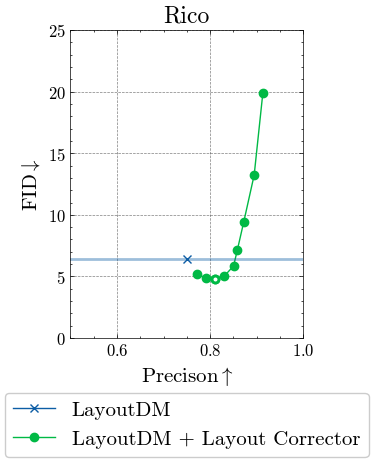

In [10]:
# Plot
fontsize = 15
fig, ax = plt.subplots(1, 1, figsize=(3, 4))

x_met, x_label = 'precision', r'Precison$\uparrow$'
y_met, y_label = 'fid', r'FID$\downarrow$'

for dic in [layoutdm, layout_corrector]:
    x = [s[x_met] for s in dic['scores']] # ms per sample
    y =  [s[y_met] for s in dic['scores']]
    ax.plot(x, y, label=dic['label'], marker=dic['marker'])

# draw horizontal line to show FID of LayoutDM
layoutdm_fid = layoutdm['scores'][0][y_met]
ax.plot([-100, 100], [layoutdm_fid, layoutdm_fid], lw=2.0, alpha=0.4, color=COLORS[0])

# LayoutDM+Corrector: plot default point with white facecolor
default_schedule_ind = 2 # index of {10, 20, 30}
corr_x = layout_corrector['scores'][default_schedule_ind][x_met]
corr_y = layout_corrector['scores'][default_schedule_ind][y_met]
ax.plot(corr_x, corr_y, ms=5, c='white', marker='o', markeredgewidth=2.1, markeredgecolor=COLORS[1])

ax.set_xlim(0.5, 1.0)
ax.set_ylim(0, 25)
ax.set_xlabel(x_label, fontsize=fontsize)
ax.set_ylabel(y_label, fontsize=fontsize)
ax.tick_params(labelsize=fontsize-3)
ax.set_title(dataset_name, fontsize=fontsize+2)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.42, 0., 0.,), fontsize=fontsize)
# ax.grid(visible=True, which='minor', linewidth=0.5);